### Primera tarea
En este primer ejercicio, para contar monedas y sus respectivos precios, una vez mostrada la imagen, esperamos a que el usuario haga clic en la moneda de 1€, para tenerla como referencia y calcular las proporciones del resto de monedas respecto a esta. 

Una vez calculadas las proporciones, se comparan con las ya declaradas en el diccionario de proporciones, y gracias a una función que busca el valor más cercano con el que coincide la proporción entre una moneda X y la de un euro, se identifica cada moneda. 

Posteriormente, gracias a otro diccionario con los valores de cada moneda, se les asigna su valor y se calcula la suma total, obteniendo la cantidad de dinero aproximada que se muestra en las monedas de la imagen.

In [6]:
import cv2
import numpy as np

# --- Cargar y preparar imagen ---
img = cv2.imread('Monedas.jpg')
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pimg = cv2.medianBlur(gris, 7)

H, W = pimg.shape[:2]
minDist = int(min(H, W) * 0.12)
maxR = int(min(H, W) * 0.4)

circ = cv2.HoughCircles(
    pimg,
    cv2.HOUGH_GRADIENT,
    1,
    minDist,
    param1=100,
    param2=50,
    minRadius=20,
    maxRadius=maxR,
)

if circ is None:
    print("No se detectaron círculos.")
    exit()

# --- Preparación de imágenes ---
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Factor de escala para la ventana de detecciones (ajusta a gusto) ---
# Por ejemplo, 0.85 para ambos ejes, o calcula para que quepa en pantalla.
scale_x = 0.8
scale_y = 0.8

# Crea una versión redimensionada SOLO para mostrar en pantalla
img_show = cv2.resize(
    img_rgb,
    (int(img_rgb.shape[1] * scale_x), int(img_rgb.shape[0] * scale_y))
)

# --- Datos de referencia (diámetro_1€ / diámetro_x) ---
proportions = {
    1.43: '1cent',
    1.24: '2cent',
    1.09: '5cent',
    1.18: '10cent',
    1.04: '20cent',
    0.96: '50cent',
    0.90: '2eur'
}

coin_values = {
    '1cent': 0.01,
    '2cent': 0.02,
    '5cent': 0.05,
    '10cent': 0.10,
    '20cent': 0.20,
    '50cent': 0.50,
    '1eur': 1.00,
    '2eur': 2.00
}

reference_diameter = None

def buscar_mas_cercano(dic, valor):
    # Si quieres mantener tu sesgo -0.03, déjalo; si prefieres sin sesgo, usa abs(k - valor)
    clave_mas_cercana = min(dic.keys(), key=lambda k: abs(k - valor - 0.03))
    return dic[clave_mas_cercana]

def mouse_click(event, x, y, flags, param):
    global reference_diameter

    if event == cv2.EVENT_LBUTTONDOWN:
        coins = param["coins"]          # círculos en coordenadas ORIGINALES
        proportions = param["proportions"]
        sx, sy = param["scale_x"], param["scale_y"]

        # 1) Convertir el clic (en imagen redimensionada) a coordenadas ORIGINALES
        x0 = x / sx
        y0 = y / sy

        # 2) Buscar moneda clicada usando coords originales
        coin_clicked = None
        for (cx, cy, r) in coins:
            if (x0 - cx)**2 + (y0 - cy)**2 <= r**2:
                coin_clicked = (cx, cy, r)
                break

        if coin_clicked is None:
            print("No se detectó ninguna moneda en el clic.")
            return

        reference_diameter = coin_clicked[-1] * 2
        print(f"Moneda seleccionada como referencia: diámetro = {reference_diameter:.2f}px")

        total = 0
        resultados = []
        for (cx, cy, r) in coins:
            d = r * 2
            proportion = reference_diameter / d
            coin_name = buscar_mas_cercano(proportions, proportion)
            if reference_diameter == d:
                coin_name = '1eur'
            valor = coin_values.get(coin_name, 0)
            total += valor
            resultados.append((cx, cy, r, coin_name, valor))
            print(f"Moneda detectada: {coin_name} ({valor:.2f}€)")

        print(f"\n TOTAL DETECTADO: {total:.2f} €")

        output = img_rgb.copy()
        for (cx, cy, r, name, val) in resultados:
            cv2.circle(output, (int(cx), int(cy)), int(r), (0, 255, 0), 2)
            cv2.putText(output, f"{name}", (int(cx) - 40, int(cy)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        cv2.putText(output, f"TOTAL: {total:.2f} EUR", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        output_show = cv2.resize(
            output, (int(output.shape[1] * sx), int(output.shape[0] * sy))
        )
        cv2.imshow("Resultado", cv2.cvtColor(output_show, cv2.COLOR_RGB2BGR))

img_show_circ = img_show.copy()
for (x, y, r) in circ[0]:
    cv2.circle(
        img_show_circ,
        (int(x * scale_x), int(y * scale_y)),
        int(r * (scale_x + scale_y) * 0.5),
        (0, 255, 0),
        2
    )

cv2.imshow("Monedas detectadas", cv2.cvtColor(img_show_circ, cv2.COLOR_RGB2BGR))
cv2.setMouseCallback(
    "Monedas detectadas",
    mouse_click,
    {"coins": circ[0], "proportions": proportions, "scale_x": scale_x, "scale_y": scale_y}
)

print("Haz clic en la moneda de referencia 1€ (en la imagen redimensionada).")
print("El programa identificará automáticamente todas las demás monedas y mostrará el total.\n")

cv2.waitKey(0)
cv2.destroyAllWindows()


Haz clic en la moneda de referencia 1€ (en la imagen redimensionada).
El programa identificará automáticamente todas las demás monedas y mostrará el total.

Moneda seleccionada como referencia: diámetro = 174.60px
Moneda detectada: 2eur (2.00€)
Moneda detectada: 5cent (0.05€)
Moneda detectada: 50cent (0.50€)
Moneda detectada: 20cent (0.20€)
Moneda detectada: 10cent (0.10€)
Moneda detectada: 1eur (1.00€)
Moneda detectada: 10cent (0.10€)
Moneda detectada: 1cent (0.01€)

 TOTAL DETECTADO: 3.96 €


### Segunda tarea

En esta segunda tarea partimos de las imágenes "FRA.png", "TAR.png" y "PEL.png" que son crops de "fragment-03-olympus-10-01-2020.JPG", "tar-03-olympus-10-01-2020.JPG" y "pellet-03-olympus-10-01-2020.JPG" respectivamente para el entrenamiento. Como añadido, se ha decidido emplear también las imágenes originales (no sólo los crops) como parte del entrenamiento, para dar más información al modelo.

Empleando los umbrales OTSU y binario, empleando también funciones de opencv para obtener contornos, areas, perímetros, compacidad, ratios y las medias de color de cada canal, entre otros métodos, se obtienen características significativas de cada una de estas imágenes (función extract_features). Mediante un bucle se extraen dichas características de cada una de las imágenes de entrenamiento. Se ha tenido en cuenta el caso en el que no se encuentren características de alguna imagen, para mostrarlo en pantalla.

Antes de pasar al entrenamiento se escalan las características, de forma que todas tengan una importancia similar y el modelo no otorgue mayor importancia a aquellas con valores más grandes.
Como modelo, se ha decidido emplear un Random Forest, que se entrena con las características ya escaladas y las etiquetas de las imágenes. Dicho entrenamiento luego se compara con los valores reales de test para calcular la matriz de confusión, su accuracy, su F1-score, etc.

Extrayendo características de entrenamiento (múltiples imágenes por clase)...
 FRA <- FRA.png: 18 características
 FRA <- fragment-03-olympus-10-01-2020.JPG: 18 características
 PEL <- PEL.png: 18 características
 PEL <- pellet-03-olympus-10-01-2020.JPG: 18 características
 TAR <- TAR.png: 18 características
 TAR <- tar-03-olympus-10-01-2020.JPG: 18 características
Distribución de muestras de entrenamiento: {'FRA': 2, 'PEL': 2, 'TAR': 2}

Entrenando clasificador Random Forest...

MÉTRICAS DE CLASIFICACIÓN
Accuracy  : 0.660 (66.0%)
Precision : 0.562
Recall    : 0.660
F1-score  : 0.598


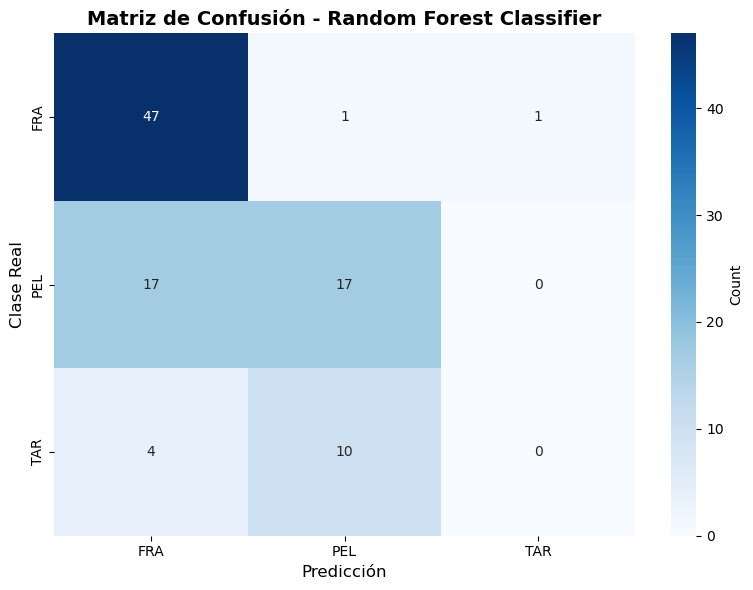

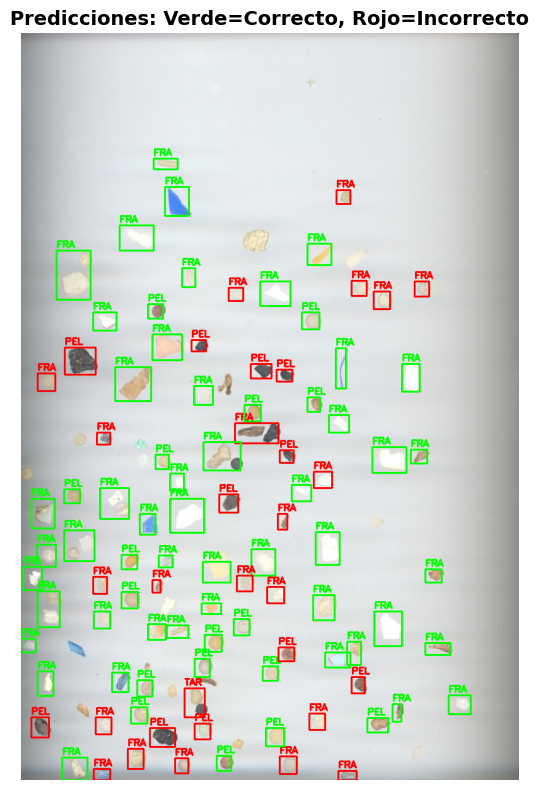

In [5]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

# Imágenes de entrenamiento
train_imgs = {
    "FRA": ["FRA.png", "fragment-03-olympus-10-01-2020.JPG"], #
    "PEL": ["PEL.png", "pellet-03-olympus-10-01-2020.JPG"], #
    "TAR": ["TAR.png", "tar-03-olympus-10-01-2020.JPG"] #
}

# Rutas de test
test_img_path = "MPs_test.jpg"
test_csv_path = "MPs_test_bbs.csv"

# Extractor de características

def extract_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Umbralizado
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if np.mean(gray[mask == 255]) > np.mean(gray[mask == 0]):
        mask = cv2.bitwise_not(mask)
    
    # Búsqueda de contornos
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    cnt = max(contours, key=cv2.contourArea)
    
    # Características geométricas
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    compacidad = (perimeter ** 2) / (area + 1e-9)
    rel_area_box = area / (w * h + 1e-9)
    aspect_ratio = w / (h + 1e-9)

    if len(cnt) >= 5:
        try:
            (_, _), (MA, ma), _ = cv2.fitEllipse(cnt)
            rel_ejes = MA / (ma + 1e-9)
        except:
            rel_ejes = 0
    else:
        rel_ejes = 0

    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0
    
    dists = [cv2.norm(np.array([cx, cy], dtype=np.float32) - p[0].astype(np.float32)) for p in cnt]
    rel_dist = min(dists) / (max(dists) + 1e-9) if len(dists) > 0 else 0
    
    # Características de color

    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    mean_b = np.mean(img[mask == 255, 0]) if np.any(mask == 255) else 0
    mean_g = np.mean(img[mask == 255, 1]) if np.any(mask == 255) else 0
    mean_r = np.mean(img[mask == 255, 2]) if np.any(mask == 255) else 0
    
    std_b = np.std(img[mask == 255, 0]) if np.any(mask == 255) else 0
    std_g = np.std(img[mask == 255, 1]) if np.any(mask == 255) else 0
    std_r = np.std(img[mask == 255, 2]) if np.any(mask == 255) else 0
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean_h = np.mean(hsv[mask == 255, 0]) if np.any(mask == 255) else 0
    mean_s = np.mean(hsv[mask == 255, 1]) if np.any(mask == 255) else 0
    mean_v = np.mean(hsv[mask == 255, 2]) if np.any(mask == 255) else 0
    
    # Solidez
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / (hull_area + 1e-9)
    
    extent = area / (w * h + 1e-9)
    
    return [
        area, perimeter, compacidad, rel_area_box, aspect_ratio, rel_ejes, rel_dist,
        mean_r, mean_g, mean_b, std_r, std_g, std_b,
        mean_h, mean_s, mean_v, solidity, extent
    ]


# Obtención de las características de cada imagen de entrenamiento

print("Extrayendo características de entrenamiento (múltiples imágenes por clase)...")
X_train = []
y_train = []

for label, paths in train_imgs.items():
    for path in paths:
        img = cv2.imread(path)
        if img is None:
            print(f"[AVISO] No se pudo cargar {path}")
            continue

        feats = extract_features(img)
        if feats is None:
            print(f"[AVISO] No se pudieron extraer características de {path}")
            continue

        X_train.append(feats)
        y_train.append(label)
        print(f" {label} <- {path}: {len(feats)} características")

cnt = Counter(y_train)
print("Distribución de muestras de entrenamiento:", dict(cnt))
faltan = [c for c in ["FRA", "PEL", "TAR"] if cnt.get(c, 0) == 0]
if faltan:
    raise RuntimeError(f"No hay muestras de entrenamiento para: {faltan}")


# Escalado y entrenamiento del modelo

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("\nEntrenando clasificador Random Forest...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None)
clf.fit(X_train_scaled, y_train)


# Procesado del archivo csv para obtener los recuadros de test y posterior
# predicción de cada recuadro.

img_test = cv2.imread(test_img_path)
if img_test is None:
    raise FileNotFoundError(f"No se encontró la imagen {test_img_path}")

y_true = []
y_pred = []

with open(test_csv_path, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row["label"]
        x_min, y_min, x_max, y_max = map(int, [
            row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        ])

        crop = img_test[y_min:y_max, x_min:x_max]
        features = extract_features(crop)

        if features is None:
            pred = "FRA"  # fallback
        else:
            features_scaled = scaler.transform([features])
            pred = clf.predict(features_scaled)[0]

        y_true.append(label)
        y_pred.append(pred)


# Métricas y matriz de confusión

print("\n" + "="*50)
print("MÉTRICAS DE CLASIFICACIÓN")
print("="*50)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy  : {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("="*50)

labels = ["FRA", "PEL", "TAR"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Clase Real", fontsize=12)
plt.title("Matriz de Confusión - Random Forest Classifier", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# Imagen final con los recuadros fruto de la predicción

colores = {"FRA": (0, 0, 255), "PEL": (0, 255, 0), "TAR": (255, 0, 0)}
img_display = img_test.copy()

with open(test_csv_path, newline="") as file:
    reader = csv.DictReader(file)
    for i, row in enumerate(reader):
        x_min, y_min, x_max, y_max = map(int, [
            row["x_min"], row["y_min"], row["x_max"], row["y_max"]
        ])
        pred = y_pred[i]
        true_label = y_true[i]

        color = (0, 255, 0) if pred == true_label else (0, 0, 255)
        cv2.rectangle(img_display, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img_display, f"{pred}", (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicciones: Verde=Correcto, Rojo=Incorrecto", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
